# [Phase 1] 데이터 파이프라인 구축 (Baseline Setup)

In [ ]:
import os
import torch
import random
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer
from getpass import getpass
from huggingface_hub import login

token = getpass('Hugging Face 토큰을 입력하세요: ')
login(token=token)

In [19]:
# 1. 시드 고정 (실험 통제를 위해 필수)
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42) # 국룰 시드 42 고정

# 2. 모델 및 토크나이저 설정
model_id = "klue/roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)

# 3. 데이터셋 로드 (수동 방식)
# NSMC 원본 깃허브에서 직접 다운로드 -> 로컬 캐시 문제나 버전 문제 해결
data_files = {
    "train": "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt",
    "test": "https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt"
}

# sep="\t"는 탭으로 구분되어 있다는 뜻입니다.
dataset = load_dataset("csv", data_files=data_files, sep="\t")
print(dataset)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})


In [20]:
# 4. 데이터 정제 (결측치 제거)
# NSMC에는 document가 None인 데이터가 아주 소량 존재함 -> 제거 안 하면 에러 발생
dataset = dataset.filter(lambda x: x['document'] is not None and len(x['document']) > 0)

# 5. 토크나이징 함수 정의
# 효율성 핵심: padding='max_length'를 여기서 하지 않고, 나중에 배치 단위로 처리(Dynamic Padding)하여 VRAM을 아낍니다.
def preprocess_function(examples):
    return tokenizer(
        examples["document"],
        truncation=True,
        max_length=128 # 영화 리뷰 특성상 128토큰이면 대부분 커버 가능 (속도/메모리 효율)
    )

# 6. 전체 데이터셋에 적용 (병렬 처리)
tokenized_datasets = dataset.map(preprocess_function, batched=True)

# ---------------------------------------------------------
# ✅ 검증: 데이터가 제대로 들어갔는지 눈으로 확인
# ---------------------------------------------------------
print("=== 데이터셋 구조 확인 ===")
print(tokenized_datasets)

print("\n=== 샘플 데이터 확인 (Original vs Tokenized) ===")
sample = tokenized_datasets['train'][0]
print(f"Original: {sample['document']}")
print(f"Label: {sample['label']} (0:부정, 1:긍정)")
print(f"Input IDs: {sample['input_ids']}")
print(f"Token Length: {len(sample['input_ids'])}")

Filter:   0%|          | 0/150000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/149995 [00:00<?, ? examples/s]

Map:   0%|          | 0/49997 [00:00<?, ? examples/s]

=== 데이터셋 구조 확인 ===
DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 149995
    })
    test: Dataset({
        features: ['id', 'document', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 49997
    })
})

=== 샘플 데이터 확인 (Original vs Tokenized) ===
Original: 아 더빙.. 진짜 짜증나네요 목소리
Label: 0 (0:부정, 1:긍정)
Input IDs: [0, 1376, 831, 2604, 18, 18, 4229, 9801, 2075, 2203, 2182, 4243, 2]
Token Length: 13


In [23]:
print(tokenized_datasets['train'][0])

{'id': 9976970, 'document': '아 더빙.. 진짜 짜증나네요 목소리', 'label': 0, 'input_ids': [0, 1376, 831, 2604, 18, 18, 4229, 9801, 2075, 2203, 2182, 4243, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


# [Phase 2] 실험군 A: Full Fine-tuning (대조군)

In [25]:
!pip install evaluate
import time
import evaluate
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.0 MB/s eta 0:00:00


In [26]:
# 1. 평가지표 로드 (Accuracy, F1)
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy.compute(predictions=predictions, references=labels)
    f1_score = f1.compute(predictions=predictions, references=labels, average="macro")
    return {"accuracy": acc["accuracy"], "f1": f1_score["f1"]}

In [27]:
# 2. 모델 초기화 (Full Fine-tuning용)
# num_labels=2 (부정:0, 긍정:1)
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)

# 모델 파라미터 수 확인 (약 1.1억 개 예상)
total_params = sum(p.numel() for p in model.parameters())
print(f"📋 총 학습 파라미터 수: {total_params:,} 개")

config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


📋 총 학습 파라미터 수: 110,619,650 개


In [29]:
# 3. 학습 하이퍼파라미터 설정 (Full Fine-tuning)
training_args = TrainingArguments(
    output_dir="./results_full_finetuning",
    learning_rate=2e-5,           # 국룰 학습률
    per_device_train_batch_size=32, # A100이면 32~64 가능 (OOM나면 16으로 줄이세요)
    per_device_eval_batch_size=32,
    num_train_epochs=3,           # 국룰 에폭 (보통 3~5)
    weight_decay=0.01,
    eval_strategy="epoch",  # 매 에폭마다 검증
    save_strategy="epoch",        # 매 에폭마다 저장
    load_best_model_at_end=True,  # 가장 성능 좋은 모델 남기기
    fp16=True,                    # GPU 메모리 절약 및 속도 향상 (Mixed Precision)
    report_to="none",             # 외부 로깅 끄기 (깔끔하게 보려고)
    seed=42
)

In [31]:
# 4. Data Collator (Dynamic Padding 적용)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 5. Trainer 정의
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [32]:
# ---------------------------------------------------------
# 🔥 학습 시작 및 리소스 측정 (핵심)
# ---------------------------------------------------------
print("\n🚀 [Phase 2] Full Fine-tuning 시작...")

# 메모리 초기화 및 측정 시작
torch.cuda.reset_peak_memory_stats()
start_time = time.time()

# 학습 수행
train_result = trainer.train()

# 측정 종료
end_time = time.time()
peak_memory = torch.cuda.max_memory_allocated() / (1024 ** 3) # GB 단위 변환


🚀 [Phase 2] Full Fine-tuning 시작...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.243700,0.232184,0.905594,0.905543
2,0.179400,0.246642,0.909935,0.909909
3,0.125100,0.286907,0.909935,0.909915


In [33]:
# ---------------------------------------------------------
# 📊 결과 리포트
# ---------------------------------------------------------
print("\n" + "="*30)
print(f"⏱️ 학습 소요 시간: {end_time - start_time:.2f} 초 (약 {(end_time - start_time)/60:.1f} 분)")
print(f"💾 Peak GPU 메모리 사용량: {peak_memory:.2f} GB")
print(f"🏆 최종 학습 Loss: {train_result.training_loss:.4f}")
print("="*30)

# 최종 평가 (Test Set)
final_metrics = trainer.evaluate()
print(f"🎯 최종 정확도(Accuracy): {final_metrics['eval_accuracy']:.4f}")
print(f"🎯 최종 F1 Score: {final_metrics['eval_f1']:.4f}")

# 메모리 해제 (다음 실험을 위해)
del model
del trainer
torch.cuda.empty_cache()


⏱️ 학습 소요 시간: 2001.25 초 (약 33.4 분)
💾 Peak GPU 메모리 사용량: 3.02 GB
🏆 최종 학습 Loss: 0.1975


🎯 최종 정확도(Accuracy): 0.9056
🎯 최종 F1 Score: 0.9055


# [Phase 3] 실험군 B: LoRA Fine-tuning (실험군)

In [34]:
!pip install peft

In [35]:
from peft import LoraConfig, get_peft_model, TaskType

# 1. 평가지표 함수 (Phase 2와 동일)
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy.compute(predictions=predictions, references=labels)
    f1_score = f1.compute(predictions=predictions, references=labels, average="macro")
    return {"accuracy": acc["accuracy"], "f1": f1_score["f1"]}

In [36]:
# 2. 모델 초기화 (Base 모델 다시 로드)
model_id = "klue/roberta-base"
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=2)

# ---------------------------------------------------------
# 🔥 [핵심] LoRA 설정 및 적용
# ---------------------------------------------------------
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, # 텍스트 분류 태스크
    inference_mode=False,
    r=8,              # Rank: 어댑터의 차원 (클수록 성능↑, 파라미터↑). 보통 8~16 사용
    lora_alpha=32,    # Alpha: 스케일링 계수 (보통 r의 2배~4배 설정)
    lora_dropout=0.1,
    target_modules=["query", "value"] # RoBERTa의 Attention Layer 중 Query, Value만 학습
)

model = get_peft_model(model, peft_config)

# 학습 가능한 파라미터 수 출력 (Phase 3의 핵심 지표)
print("\n=== LoRA 파라미터 통계 ===")
model.print_trainable_parameters()
print("==========================\n")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== LoRA 파라미터 통계 ===
trainable params: 887,042 || all params: 111,506,692 || trainable%: 0.7955



In [37]:
# 3. 학습 하이퍼파라미터 설정 (LoRA 최적화)
# 주의: LoRA는 Full Fine-tuning보다 학습률(LR)을 높게 잡아야 학습이 잘 됩니다. (2e-5 -> 2e-4)
training_args = TrainingArguments(
    output_dir="./results_lora_finetuning",
    learning_rate=2e-4,           # LoRA는 더 높은 LR 필요
    per_device_train_batch_size=32, # 동일 배치 사이즈로 메모리 절감 효과 비교
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=True,
    report_to="none",
    seed=42
)

# 4. Trainer 정의
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    processing_class=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

In [38]:
# ---------------------------------------------------------
# 🔥 학습 시작 및 리소스 측정
# ---------------------------------------------------------
print("\n🚀 [Phase 3] LoRA Fine-tuning 시작...")

torch.cuda.reset_peak_memory_stats()
start_time = time.time()

train_result = trainer.train()

end_time = time.time()
peak_memory = torch.cuda.max_memory_allocated() / (1024 ** 3)

# ---------------------------------------------------------
# 📊 결과 리포트
# ---------------------------------------------------------
print("\n" + "="*30)
print(f"⏱️ 학습 소요 시간: {end_time - start_time:.2f} 초")
print(f"💾 Peak GPU 메모리 사용량: {peak_memory:.2f} GB")
print(f"🏆 최종 학습 Loss: {train_result.training_loss:.4f}")
print("="*30)

final_metrics = trainer.evaluate()
print(f"🎯 최종 정확도(Accuracy): {final_metrics['eval_accuracy']:.4f}")
print(f"🎯 최종 F1 Score: {final_metrics['eval_f1']:.4f}")


🚀 [Phase 3] LoRA Fine-tuning 시작...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.270100,0.258191,0.895314,0.895310
2,0.241500,0.250385,0.901734,0.901707
3,0.227800,0.243224,0.903934,0.903909



⏱️ 학습 소요 시간: 1463.34 초
💾 Peak GPU 메모리 사용량: 1.85 GB
🏆 최종 학습 Loss: 0.2605


🎯 최종 정확도(Accuracy): 0.9039
🎯 최종 F1 Score: 0.9039


# [Phase 4] 비교 분석 및 시각화 (Analysis)

In [51]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

In [52]:
results = {
    "Model": ["Full Fine-tuning", "LoRA Fine-tuning"],
    
    # 파라미터 수 (1.1억개 vs 88만개)
    "Trainable Params": [111506692, 887042], 
    
    # 학습 소요 시간 (초)
    "Training Time (sec)": [2001.25, 1463.34], 
    
    # Peak GPU 메모리 (GB)
    "Peak VRAM (GB)": [3.02, 1.85],
    
    # 최종 정확도
    "Accuracy": [0.9056, 0.9039],
    
    # 최종 F1 Score
    "F1 Score": [0.9055, 0.9039]
}

In [55]:
def recover_all_logs(folder_name):
    checkpoints = sorted(glob(f"{folder_name}/checkpoint-*"), key=os.path.getmtime)
    if not checkpoints:
        return [], []
    
    state_file = os.path.join(checkpoints[-1], "trainer_state.json")
    if not os.path.exists(state_file):
        return [], []
        
    with open(state_file, "r") as f:
        data = json.load(f)
    
    # Training Loss (step 기준)
    train_log = [x for x in data["log_history"] if "loss" in x]
    # Validation Loss (step 기준)
    val_log = [x for x in data["log_history"] if "eval_loss" in x]
    
    return train_log, val_log

loss_full_train, loss_full_val = recover_all_logs("./results_full_finetuning")
loss_lora_train, loss_lora_val = recover_all_logs("./results_lora_finetuning")

/tmp/ipython-input-204608553.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Trainable Params", data=results, palette=["#ff9999", "#66b3ff"], ax=ax1)
/tmp/ipython-input-204608553.py:60: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-204608553.py:60: UserWarning: Glyph 128190 (\N{FLOPPY DISK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-204608553.py:60: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-204608553.py:61: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.savefig("final_analysis_with_val_loss.png", dpi=300)
/tmp/ipython-input-204608553.py:61: UserWarning: Glyph 128190 (\N{FLOPPY DISK}) missing from font(

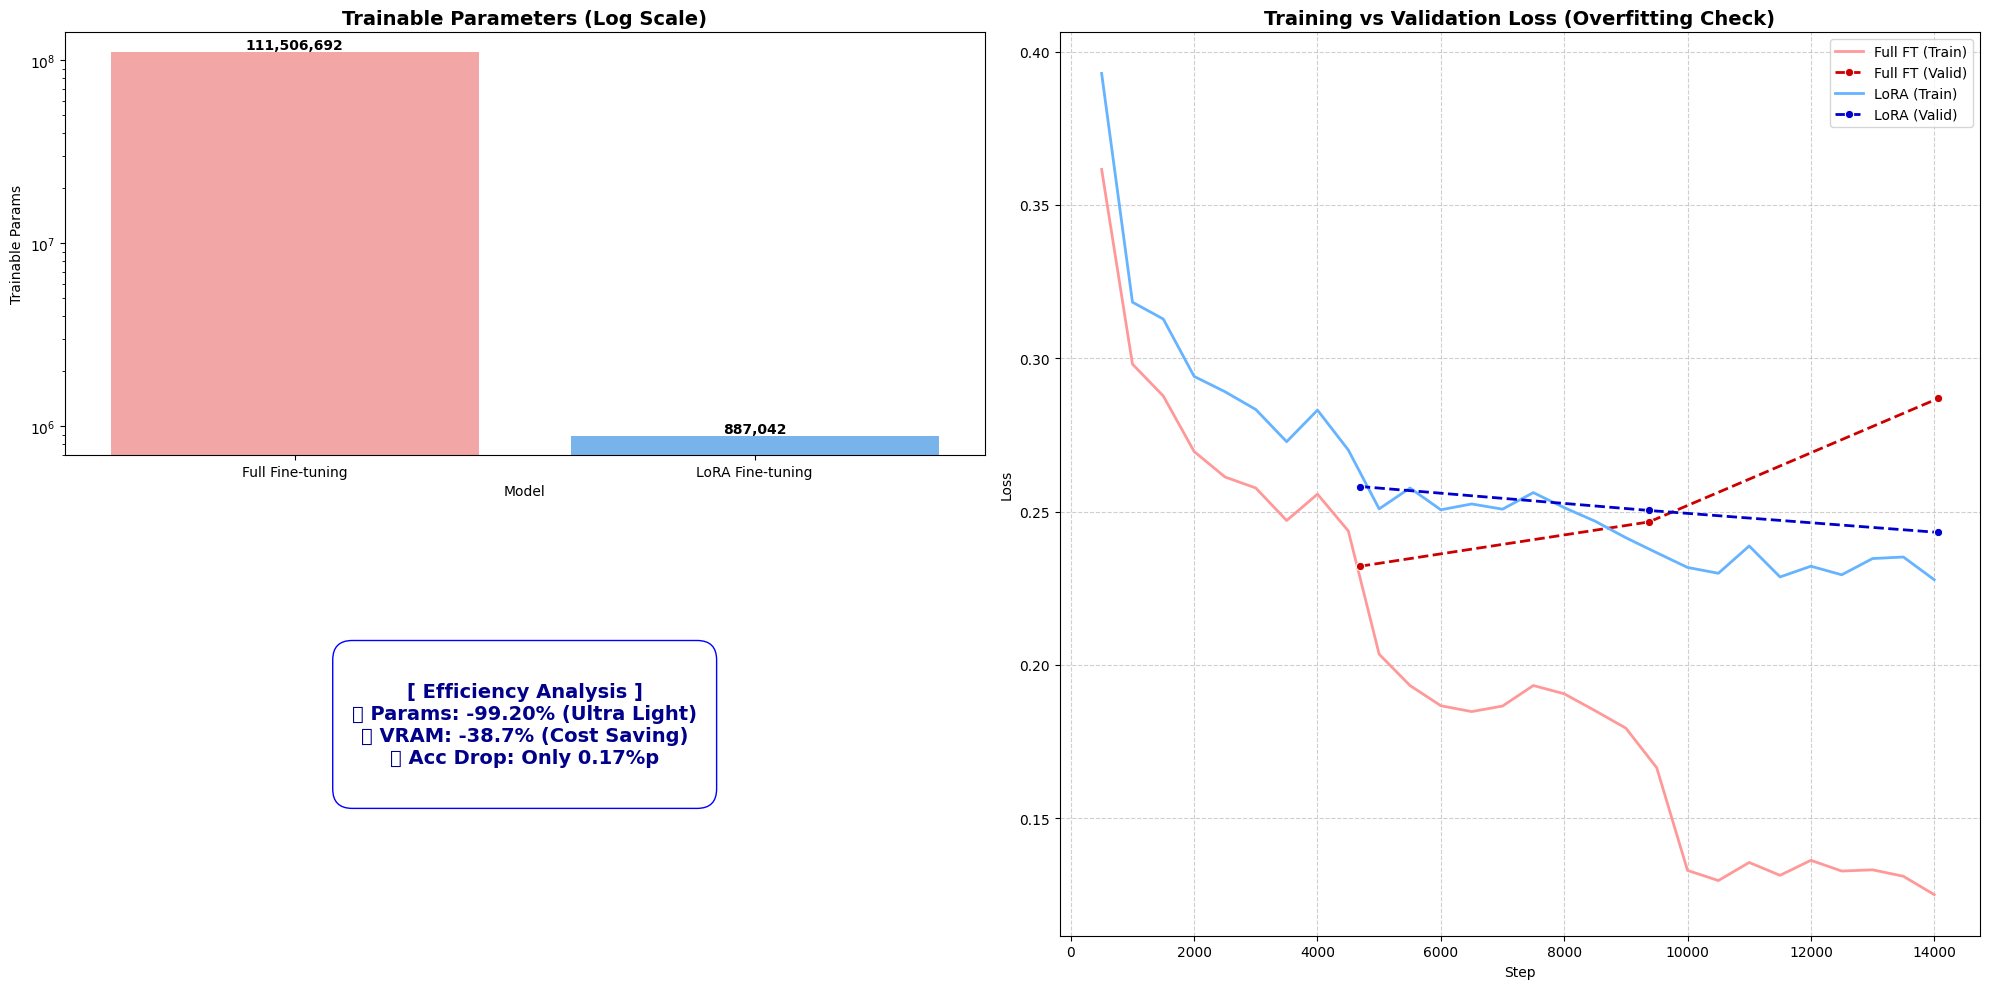

In [57]:
plt.rcParams['font.family'] = 'DejaVu Sans' 
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(2, 2)

# [Chart 1] 파라미터 수 (Bar) - 좌측 상단
ax1 = fig.add_subplot(gs[0, 0])
sns.barplot(x="Model", y="Trainable Params", data=results, palette=["#ff9999", "#66b3ff"], ax=ax1)
ax1.set_title("Trainable Parameters (Log Scale)", fontsize=14, fontweight='bold')
ax1.set_yscale("log")
for i, v in enumerate(results["Trainable Params"]):
    ax1.text(i, v, f"{v:,}", ha='center', va='bottom', fontweight='bold')

# [Chart 2] Loss Curve (Train vs Validation) - 우측 상단 & 하단 병합
ax2 = fig.add_subplot(gs[:, 1]) # 오른쪽 전체 사용

# Full Fine-tuning 그리기
if loss_full_train:
    sns.lineplot(x=[x['step'] for x in loss_full_train], y=[x['loss'] for x in loss_full_train], 
                 label="Full FT (Train)", color="#ff9999", ax=ax2, linewidth=2)
    sns.lineplot(x=[x['step'] for x in loss_full_val], y=[x['eval_loss'] for x in loss_full_val], 
                 label="Full FT (Valid)", color="#cc0000", ax=ax2, linestyle='--', marker='o', linewidth=2)

# LoRA 그리기
if loss_lora_train:
    sns.lineplot(x=[x['step'] for x in loss_lora_train], y=[x['loss'] for x in loss_lora_train], 
                 label="LoRA (Train)", color="#66b3ff", ax=ax2, linewidth=2)
    sns.lineplot(x=[x['step'] for x in loss_lora_val], y=[x['eval_loss'] for x in loss_lora_val], 
                 label="LoRA (Valid)", color="#0000cc", ax=ax2, linestyle='--', marker='o', linewidth=2)

ax2.set_title("Training vs Validation Loss (Overfitting Check)", fontsize=14, fontweight='bold')
ax2.set_xlabel("Step")
ax2.set_ylabel("Loss")
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend()

# [Table] 요약 - 좌측 하단
ax3 = fig.add_subplot(gs[1, 0])
ax3.axis('off')
df_results = pd.DataFrame(results)

# 효율성 계산
full_p = df_results.loc[0, "Trainable Params"]
lora_p = df_results.loc[1, "Trainable Params"]
full_v = df_results.loc[0, "Peak VRAM (GB)"]
lora_v = df_results.loc[1, "Peak VRAM (GB)"]

param_red = (1 - lora_p/full_p)*100
mem_red = (1 - lora_v/full_v)*100
acc_drop = results["Accuracy"][0] - results["Accuracy"][1]

summary_text = f"""
[ Efficiency Analysis ]
🚀 Params: -{param_red:.2f}% (Ultra Light)
💾 VRAM: -{mem_red:.1f}% (Cost Saving)
📉 Acc Drop: Only {acc_drop*100:.2f}%p
"""
ax3.text(0.5, 0.5, summary_text, ha='center', va='center', fontsize=14, color='darkblue', fontweight='bold', 
         bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round,pad=1'))

plt.tight_layout()
plt.savefig("final_analysis_with_val_loss.png", dpi=300)
plt.show()

/tmp/ipython-input-1890073995.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Count", data=param_data, palette=["#ff9999", "#66b3ff"], ax=ax1)
/tmp/ipython-input-1890073995.py:132: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  plt.savefig("final_analysis_with_detail_table.png", dpi=300)
/tmp/ipython-input-1890073995.py:132: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig("final_analysis_with_detail_table.png", dpi=300)


✅ 표가 포함된 최종 분석 이미지가 저장되었습니다.


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


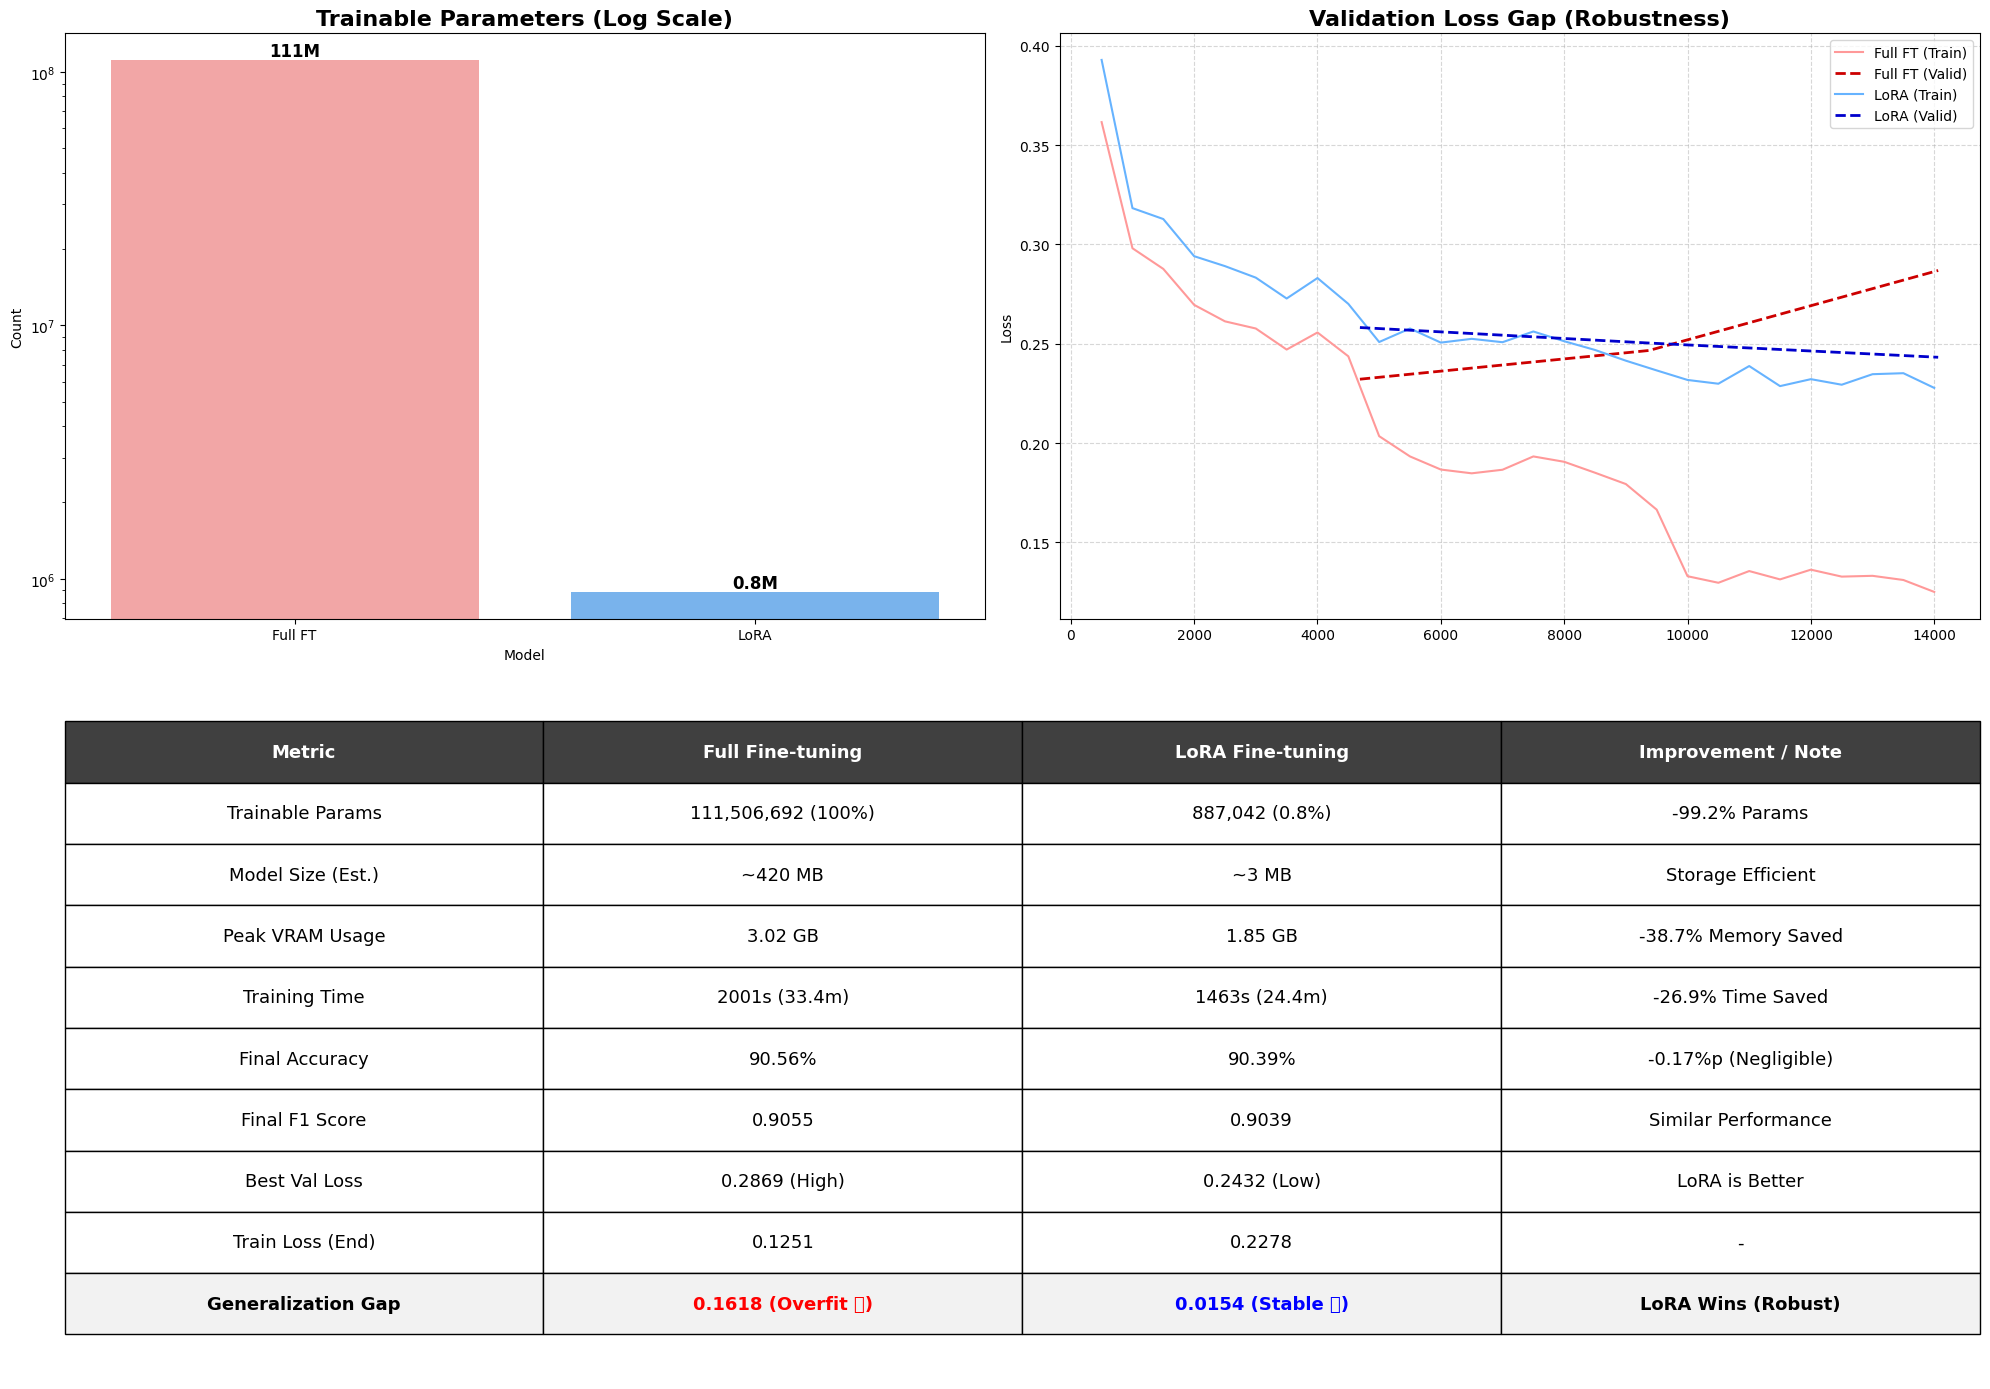

In [59]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

# ==============================================================================
# 1. [입력] 실험 결과값 (모든 수치 상세 입력)
# ==============================================================================
# 사용자가 제공한 로그 기반 팩트 데이터
results = {
    "Metric": [
        "Trainable Params", 
        "Model Size (Est.)",
        "Peak VRAM Usage", 
        "Training Time", 
        "Final Accuracy", 
        "Final F1 Score", 
        "Best Val Loss",
        "Train Loss (End)",
        "Generalization Gap" # (Val Loss - Train Loss) : 클수록 과적합 심함
    ],
    "Full Fine-tuning": [
        "111,506,692 (100%)", 
        "~420 MB",
        "3.02 GB", 
        "2001s (33.4m)", 
        "90.56%", 
        "0.9055", 
        "0.2869 (High)", # 과적합 징후
        "0.1251", 
        "0.1618 (Overfit 🚨)" 
    ],
    "LoRA Fine-tuning": [
        "887,042 (0.8%)", 
        "~3 MB",
        "1.85 GB", 
        "1463s (24.4m)", 
        "90.39%", 
        "0.9039", 
        "0.2432 (Low)", # 안정적
        "0.2278", 
        "0.0154 (Stable ✅)"
    ],
    "Improvement / Note": [
        "-99.2% Params", 
        "Storage Efficient",
        "-38.7% Memory Saved", 
        "-26.9% Time Saved", 
        "-0.17%p (Negligible)", 
        "Similar Performance",
        "LoRA is Better",
        "-",
        "LoRA Wins (Robust)"
    ]
}

# ==============================================================================
# 2. [복구] Loss Log 자동 추출 (그래프용)
# ==============================================================================
def recover_all_logs(folder_name):
    checkpoints = sorted(glob(f"{folder_name}/checkpoint-*"), key=os.path.getmtime)
    if not checkpoints: return [], []
    state_file = os.path.join(checkpoints[-1], "trainer_state.json")
    if not os.path.exists(state_file): return [], []
    with open(state_file, "r") as f: data = json.load(f)
    return [x for x in data["log_history"] if "loss" in x], [x for x in data["log_history"] if "eval_loss" in x]

loss_full_train, loss_full_val = recover_all_logs("./results_full_finetuning")
loss_lora_train, loss_lora_val = recover_all_logs("./results_lora_finetuning")

# ==============================================================================
# 3. 시각화 (테이블 강조형)
# ==============================================================================
plt.rcParams['font.family'] = 'DejaVu Sans' 
fig = plt.figure(figsize=(20, 14)) # 세로 길이 늘림
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.2]) # 테이블 영역(아래쪽)을 더 넓게 잡음

# [Chart 1] 파라미터 수 (Bar)
ax1 = fig.add_subplot(gs[0, 0])
# 파라미터 숫자만 추출해서 그리기
param_data = {"Model": ["Full FT", "LoRA"], "Count": [111506692, 887042]}
sns.barplot(x="Model", y="Count", data=param_data, palette=["#ff9999", "#66b3ff"], ax=ax1)
ax1.set_title("Trainable Parameters (Log Scale)", fontsize=16, fontweight='bold')
ax1.set_yscale("log")
ax1.text(0, 111506692, "111M", ha='center', va='bottom', fontsize=12, fontweight='bold')
ax1.text(1, 887042, "0.8M", ha='center', va='bottom', fontsize=12, fontweight='bold')

# [Chart 2] Loss Curve (Overfitting Check)
ax2 = fig.add_subplot(gs[0, 1])
if loss_full_train:
    sns.lineplot(x=[x['step'] for x in loss_full_train], y=[x['loss'] for x in loss_full_train], 
                 label="Full FT (Train)", color="#ff9999", ax=ax2)
    sns.lineplot(x=[x['step'] for x in loss_full_val], y=[x['eval_loss'] for x in loss_full_val], 
                 label="Full FT (Valid)", color="#cc0000", ax=ax2, linestyle='--', linewidth=2)
if loss_lora_train:
    sns.lineplot(x=[x['step'] for x in loss_lora_train], y=[x['loss'] for x in loss_lora_train], 
                 label="LoRA (Train)", color="#66b3ff", ax=ax2)
    sns.lineplot(x=[x['step'] for x in loss_lora_val], y=[x['eval_loss'] for x in loss_lora_val], 
                 label="LoRA (Valid)", color="#0000cc", ax=ax2, linestyle='--', linewidth=2)
ax2.set_title("Validation Loss Gap (Robustness)", fontsize=16, fontweight='bold')
ax2.set_ylabel("Loss")
ax2.grid(True, linestyle='--', alpha=0.5)

# [Table] 상세 비교 분석 표
ax3 = fig.add_subplot(gs[1, :])
ax3.axis('off')

df_results = pd.DataFrame(results)

# 테이블 그리기
table = ax3.table(cellText=df_results.values, colLabels=df_results.columns, loc='center', cellLoc='center')

# 테이블 스타일링
table.auto_set_font_size(False)
table.set_fontsize(13)
table.scale(1, 2.8) # 테이블 높이 키움

# 헤더 색상 및 볼드 처리
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#404040')
    else:
        # 특정 행 강조 (Overfitting Gap)
        if df_results.iloc[row-1, 0] == "Generalization Gap":
            cell.set_text_props(weight='bold', color='red' if col==1 else ('blue' if col==2 else 'black'))
            cell.set_facecolor('#f2f2f2')

plt.tight_layout()
plt.savefig("final_analysis_with_detail_table.png", dpi=300)
print("✅ 표가 포함된 최종 분석 이미지가 저장되었습니다.")
plt.show()